In [1]:
from ga_regression import *
from ga_dataset import *
from matplotlib import pyplot as plt
from functools import partial
import PIL
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from pvutils import iter_subplots
from pyvista import PolyData
import pyvista as pv
from scipy.stats import pearsonr



C:\Users\dg\.conda\envs\diffnet4\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
@dataclass
class SourceModel:
    trained_file: str
    trained_idx: int
    cp_data_file: str

    def load_corpus_data(
        self,
        model_idx: int,
    ):
        reader = Readers.from_file(self.trained_file)[self.trained_idx]
        
        ga_ndata = NeurophysData.load_data(
            data_file=reader.metadata.opts.data_file,
            file_mode=reader.metadata.opts.mesh_file_mode,
            spike_window=reader.metadata.spike_window,
            n_faces=reader.metadata.n_faces,
            features=None,
            n_min_reps=3,
        )
    
        ga_responses = ga_ndata.responses.loc[:, reader.metadata.channel]
        ga_r_min = ga_responses.min(axis=0)
        ga_r_max = ga_responses.max(axis=0)
    
        cp_ndata = NeurophysData.load_data(
            data_file=self.cp_data_file,
            file_mode='thumbnail',
            spike_window=reader.metadata.spike_window,
            n_faces=None,
            features=None,
            n_min_reps=None,
        )
    
        # Normalize to ga min/max
        cp_responses = (cp_ndata.responses.loc[:, reader.metadata.channel] - ga_r_min) / (ga_r_max - ga_r_min)
    
        # Replace scene ids with filenames
        cp_responses = cp_responses.set_index(cp_ndata.scenes.filename.loc[cp_responses.index])
    
        # Update column indices
        tuples = [(model_idx, i) for i in range(len(reader.metadata.channel))]
        cp_responses.columns = pd.MultiIndex.from_tuples(tuples, names=["model_idx", "channel_idx"])
        return cp_responses


In [3]:
models = [
    SourceModel(
        trained_file=r"D:\resynth\run_09_10\run00009_resynth\2025-07-27-12-12-10\opts_and_metadata.pt",
        trained_idx=0,
        cp_data_file=r"D:\resynth\run_09_10\run00010_exported\run00010_exported.hdf",
    ),
    SourceModel(
        trained_file=r"D:\resynth\run_20_21\run00020_resynth\2025-07-29-15-37-40\opts_and_metadata.pt",
        trained_idx=1,
        cp_data_file=r"D:\resynth\run_20_21\run00021_exported\run00021_exported.hdf",
    ),
    
]
cp_responses = pd.concat([
    tm.load_corpus_data(model_idx=i)
    for i, tm in enumerate(models)
], axis=1)

cp_responses

model_idx                                            0                 \
channel_idx                                          0         1    2   
filename                                                                
6380.JPG                                      0.033333  0.495726  0.0   
shutterstock_669515833.jpg                    0.005556  0.709402  0.0   
Lamp_v3_orig.png                              0.000000  0.068376  0.0   
shutterstock_2298530729.jpg                   0.044444  0.752137  0.0   
shutterstock_1868033938.jpg                   0.011111  0.478632  0.0   
...                                                ...       ...  ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png       0.044444  0.803419  0.0   
JF0N2N0B_VervetMonkeys_Walk_v4_orig_Main.png  0.033333  0.427350  0.0   
Cicada_Crawl_v3_orig.png                      0.066667  0.752137  0.0   
Squirrel_v4_orig_Forepaw.png                  0.033333  0.905983  0.0   
shutterstock_109621682.jpg                    0.011111  0.136752  0.0   

model_idx                                                                   \
channel_idx                                          3         4         5   
filename                                                                     
6380.JPG                                      0.406780  0.423729  0.465116   
shutterstock_669515833.jpg                    0.398305  0.423729  0.441860   
Lamp_v3_orig.png                              0.338983  0.474576  0.325581   
shutterstock_2298530729.jpg                   0.271186  0.355932  0.325581   
shutterstock_1868033938.jpg                   0.305085  0.525424  0.418605   
...                                                ...       ...       ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png       0.525424  0.661017  0.744186   
JF0N2N0B_VervetMonkeys_Walk_v4_orig_Main.png  0.203390  0.457627  0.465116   
Cicada_Crawl_v3_orig.png                      1.118644  1.135593  1.116279   
Squirrel_v4_orig_Forepaw.png                  0.440678  0.627119  0.441860   
shutterstock_109621682.jpg                    0.322034  0.440678  0.325581   

model_idx                                                                   \
channel_idx                                          6         7         8   
filename                                                                     
6380.JPG                                      0.044444  0.020833  0.333333   
shutterstock_669515833.jpg                    0.255556  0.000000  0.566667   
Lamp_v3_orig.png                              0.111111  0.000000  0.200000   
shutterstock_2298530729.jpg                   0.111111  0.020833  0.466667   
shutterstock_1868033938.jpg                   0.022222  0.000000  0.400000   
...                                                ...       ...       ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png       0.066667  0.000000  0.266667   
JF0N2N0B_VervetMonkeys_Walk_v4_orig_Main.png  0.022222  0.000000  0.666667   
Cicada_Crawl_v3_orig.png                      0.133333  0.062500  0.533333   
Squirrel_v4_orig_Forepaw.png                  0.044444  0.020833  0.400000   
shutterstock_109621682.jpg                    0.000000  0.000000  0.266667   

model_idx                                                      1            \
channel_idx                                          9         0         1   
filename                                                                     
6380.JPG                                      0.222222  0.376812  0.254098   
shutterstock_669515833.jpg                    0.000000  0.202899  0.114754   
Lamp_v3_orig.png                              0.000000  0.166667  0.163934   
shutterstock_2298530729.jpg                   0.222222  0.463768  0.131148   
shutterstock_1868033938.jpg                   0.111111  0.304348  0.147541   
...                                                ...       ...       ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png       0.111111  0.434783  0.327869   
JF0N2N0B_Ve

In [4]:
cp_responses

model_idx                                            0                 \
channel_idx                                          0         1    2   
filename                                                                
6380.JPG                                      0.033333  0.495726  0.0   
shutterstock_669515833.jpg                    0.005556  0.709402  0.0   
Lamp_v3_orig.png                              0.000000  0.068376  0.0   
shutterstock_2298530729.jpg                   0.044444  0.752137  0.0   
shutterstock_1868033938.jpg                   0.011111  0.478632  0.0   
...                                                ...       ...  ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png       0.044444  0.803419  0.0   
JF0N2N0B_VervetMonkeys_Walk_v4_orig_Main.png  0.033333  0.427350  0.0   
Cicada_Crawl_v3_orig.png                      0.066667  0.752137  0.0   
Squirrel_v4_orig_Forepaw.png                  0.033333  0.905983  0.0   
shutterstock_109621682.jpg                    0.011111  0.136752  0.0   

model_idx                                                                   \
channel_idx                                          3         4         5   
filename                                                                     
6380.JPG                                      0.406780  0.423729  0.465116   
shutterstock_669515833.jpg                    0.398305  0.423729  0.441860   
Lamp_v3_orig.png                              0.338983  0.474576  0.325581   
shutterstock_2298530729.jpg                   0.271186  0.355932  0.325581   
shutterstock_1868033938.jpg                   0.305085  0.525424  0.418605   
...                                                ...       ...       ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png       0.525424  0.661017  0.744186   
JF0N2N0B_VervetMonkeys_Walk_v4_orig_Main.png  0.203390  0.457627  0.465116   
Cicada_Crawl_v3_orig.png                      1.118644  1.135593  1.116279   
Squirrel_v4_orig_Forepaw.png                  0.440678  0.627119  0.441860   
shutterstock_109621682.jpg                    0.322034  0.440678  0.325581   

model_idx                                                                   \
channel_idx                                          6         7         8   
filename                                                                     
6380.JPG                                      0.044444  0.020833  0.333333   
shutterstock_669515833.jpg                    0.255556  0.000000  0.566667   
Lamp_v3_orig.png                              0.111111  0.000000  0.200000   
shutterstock_2298530729.jpg                   0.111111  0.020833  0.466667   
shutterstock_1868033938.jpg                   0.022222  0.000000  0.400000   
...                                                ...       ...       ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png       0.066667  0.000000  0.266667   
JF0N2N0B_VervetMonkeys_Walk_v4_orig_Main.png  0.022222  0.000000  0.666667   
Cicada_Crawl_v3_orig.png                      0.133333  0.062500  0.533333   
Squirrel_v4_orig_Forepaw.png                  0.044444  0.020833  0.400000   
shutterstock_109621682.jpg                    0.000000  0.000000  0.266667   

model_idx                                                      1            \
channel_idx                                          9         0         1   
filename                                                                     
6380.JPG                                      0.222222  0.376812  0.254098   
shutterstock_669515833.jpg                    0.000000  0.202899  0.114754   
Lamp_v3_orig.png                              0.000000  0.166667  0.163934   
shutterstock_2298530729.jpg                   0.222222  0.463768  0.131148   
shutterstock_1868033938.jpg                   0.111111  0.304348  0.147541   
...                                                ...       ...       ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png       0.111111  0.434783  0.327869   
JF0N2N0B_Ve

In [23]:
target = cp_responses.iloc[0].rename('what')
target = target / (target ** 2).sum()
target

model_idx  channel_idx
0          0              0.023468
           1              0.349012
           2              0.000000
           3              0.286390
           4              0.298323
           5              0.327462
           6              0.031291
           7              0.014668
           8              0.234681
           9              0.156454
1          0              0.265291
           1              0.178896
           2              0.000000
           3              0.020506
           4              0.096006
           5              0.328553
           6              0.052151
Name: what, dtype: float64

In [35]:
df_predictions = cp_responses.stack(['model_idx', 'channel_idx']).to_frame().reset_index()
df_predictions

,filename,model_idx,channel_idx,0
0,6380.JPG,0,0,0.033333
1,6380.JPG,0,1,0.495726
2,6380.JPG,0,2,0.000000
3,6380.JPG,0,3,0.406780
4,6380.JPG,0,4,0.423729
...,...,...,...,...
3310,shutterstock_109621682.jpg,1,2,0.000000
3311,shutterstock_109621682.jpg,1,3,0.000000
3312,shutterstock_109621682.jpg,1,4,0.036364
3313,shutterstock_109621682.jpg,1,5,0.200000


In [36]:
df_predictions.set_index(['filename', 'model_idx', 'channel_idx'])

0
filename                   model_idx channel_idx          
6380.JPG                   0         0            0.033333
                                     1            0.495726
                                     2            0.000000
                                     3            0.406780
                                     4            0.423729
...                                                    ...
shutterstock_109621682.jpg 1         2            0.000000
                                     3            0.000000
                                     4            0.036364
                                     5            0.200000
                                     6            0.018519

[3315 rows x 1 columns]

In [29]:
(cp_responses * target).sum(axis=1)

filename
6380.JPG                                        1.000000
shutterstock_669515833.jpg                      1.028615
Lamp_v3_orig.png                                0.642714
shutterstock_2298530729.jpg                     1.246249
shutterstock_1868033938.jpg                     1.111065
                                                  ...   
JF0N2N0A_Chipmunk_Play_v4_orig_Main.png         1.538718
JF0N2N0B_VervetMonkeys_Walk_v4_orig_Main.png    1.254404
Cicada_Crawl_v3_orig.png                        1.920646
Squirrel_v4_orig_Forepaw.png                    1.426412
shutterstock_109621682.jpg                      0.628951
Length: 195, dtype: float64

In [22]:
cp_responses.groupby('filename').apply(lambda g: (g * target).sum(axis=1))

filename                               filename                             
0QWUPd4sT0m8uk9z8SfUOg_thumb_59c5.jpg  0QWUPd4sT0m8uk9z8SfUOg_thumb_59c5.jpg    1.110089
136.JPG                                136.JPG                                  1.211003
1446.JPG                               1446.JPG                                 1.492430
20220308_SD02_3022.JPG                 20220308_SD02_3022.JPG                   1.723227
20220419_SD02_4424.JPG                 20220419_SD02_4424.JPG                   1.705891
                                                                                  ...   
shutterstock_749507503.jpg             shutterstock_749507503.jpg               1.642854
shutterstock_78186766.jpg              shutterstock_78186766.jpg                1.469089
shutterstock_785216149.jpg             shutterstock_785216149.jpg               1.655599
shutterstock_788770174.jpg             shutterstock_788770174.jpg               1.501917
shutterstock_80325520.jpg        

In [17]:
cp_responses.groupby('filename').apply(lambda g: (g * target).sum(axis=1))

In [20]:
(g * target).sum(axis=1)

filename
0QWUPd4sT0m8uk9z8SfUOg_thumb_59c5.jpg    1.576736
dtype: float64

In [5]:
mag = cp_responses.sum(axis=1)
best_stim = cp_responses.iloc[mag.argmax()]

In [6]:
for tm, (model_idx, target) in zip(models, best_stim.groupby('model_idx')):
    s = f"""
    - (): cemetery.diffnet.TrainedModel
      file: '{tm.trained_file}'
      idx: {tm.trained_idx}
      target: [{', '.join(f'{x:.04f}' for x in target.values)}]"""
    print(s[1:])

    - (): cemetery.diffnet.TrainedModel
      file: 'D:\resynth\run_09_10\run00009_resynth\2025-07-27-12-12-10\opts_and_metadata.pt'
      idx: 0
      target: [0.1556, 0.8718, 0.0000, 0.9322, 0.9492, 1.0930, 0.3111, 0.0208, 1.0667, 0.2222]
    - (): cemetery.diffnet.TrainedModel
      file: 'D:\resynth\run_20_21\run00020_resynth\2025-07-29-15-37-40\opts_and_metadata.pt'
      idx: 1
      target: [0.3623, 0.2869, 0.0000, 0.0388, 0.2727, 1.1333, 0.2870]


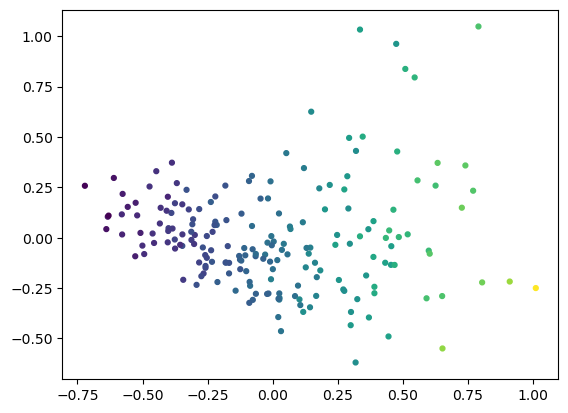

In [7]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(cp_responses);

x = pca.transform(cp_responses)
plt.scatter(x[:, 0], x[:, 1], 12, mag)